NLO/LO EWK corrections + NLO/LO (EWK+QCD) uncertainties

In [1]:
from coffea.nanoevents import NanoEventsFactory
import awkward as ak
import numpy as np
import hist
import pandas as pd
import uproot
import json
import matplotlib.pyplot as plt

In [2]:
def blocks(lines):
    lines = iter(lines)
    tag, block = "", []
    try:
        while True:
            line = next(lines)
            begintag = "# BEGIN "
            if line.startswith(begintag):
                tag = line[len(begintag):]
                block = []
            elif line.startswith("# END "):
                yield tag, block
            elif len(line):
                block.append(line)
    except StopIteration:
        pass


def tohist(block):
    assert block[0] == '# xlow   xhigh   val   errminus  errplus'
    data = np.fromstring(" ".join(block[1:]), sep=" ").reshape(-1, 5)
    assert np.all(data[1:, 0] == data[:-1, 1])
    edges = np.concatenate([data[:, 0], data[-1:, 1]])
    val, lo, hi = data[:, 2:].T
    h = hist.Hist.new.Var(edges).Weight()
    h.view().value = val
    h.view().variance = (hi - lo)**2 / 4
    return h


def load_yoda(lines):
    hists = {}
    data = {}
    for tag, block in blocks(lines.split("\n")):
        if tag.startswith("HISTO1D"):
            hists[tag[8:]] = tohist(block)
        elif tag.startswith("DATA"):
            for l in block:
                k, v = l.split("=")
                data[k] = v
    return data, hists

In [3]:
import requests
#Theory paper https://arxiv.org/abs/1705.04664
eejmeta, eej = load_yoda(requests.get("https://www.ippp.dur.ac.uk/~jlindert/vjets/eej.dat").text)
vvjmeta, vvj = load_yoda(requests.get("https://www.ippp.dur.ac.uk/~jlindert/vjets/vvj.dat").text)
evjmeta, evj = load_yoda(requests.get("https://www.ippp.dur.ac.uk/~jlindert/vjets/evj.dat").text)
lindert = dict(**eej, **vvj, **evj)

In [4]:
def make_lindert_pred(process, order):
    """Eqn. 76 of https://arxiv.org/pdf/1705.04664.pdf
    
    process: eej, evj, vvj; order: NLO, NNLO
    """
    sigma_lo = lindert[f"{process}_pTV_LO"].values()
    kqcd = lindert[f"{process}_pTV_K_{order}"].values()
    deltas = np.empty((3 + 106, len(kqcd)))
    kewk = lindert[f"{process}_pTV_kappa_EW"].values()
    deltas_ew = np.empty((3, len(kqcd)))
    delta_mix = lindert[f"{process}_pTV_dK_{order}_mix"].values()[None, :]

    for i in range(3):
        deltas[i, :] = lindert[f"{process}_pTV_d{i + 1}K_{order}"].values()

    for i in range(106):
        deltas[i + 3, :] = lindert[f"{process}_pTV_dK_PDF_{i + 1}"].values()

    for i in range(3):
        deltas_ew[i, :] = lindert[f"{process}_pTV_d{i + 1}kappa_EW"].values()

    def pred(epsilon, ew=True):
        """epsilon: (*, 3 + 106 + 3 + 1) (qcd scale, pdf, ewk variation, cross-term)"""
        Kth = (kqcd + epsilon[..., :109] @ deltas)
        if ew:
            Kth *= (1 + kewk + epsilon[..., 109:112] @ deltas_ew)
            Kth += epsilon[..., 112:113] @ delta_mix
        return Kth * sigma_lo
    
    return pred

In [5]:
from correctionlib.schemav2 import CorrectionSet, Correction, Variable
from correctionlib.convert import from_histogram
import correctionlib

def evaluator(corr):
    cset = CorrectionSet(schema_version=2, corrections=[corr])
    return np.vectorize(
        correctionlib.CorrectionSet(cset)[corr.name].evaluate,
    )

vptvar = Variable(
    name="vpt",
    type="real",
    description="Generated boson pT (status 62: fromHardProcess, isLastCopy) or sum(leptons).pt if virtual"
)

In [6]:
order = "NLO"
eej_qcd = make_lindert_pred("eej", order)
evj_qcd = make_lindert_pred("evj", order)
wpedges = lindert["vvj_pTV_NLO"].axes[0].edges

In [7]:
#Z EWK correction + combined QCD+EWK NLO correction uncertainties
edges = wpedges
den = lindert["eej_pTV_LO"].values() * lindert["eej_pTV_K_NLO"].values()

def binning(idx, shift):
    epsilon = np.zeros(113)
    epsilon[idx] = shift
    return {
        "nodetype": "binning",
        "input": "vpt",
        "edges": list(edges),
        "content": list(eej_qcd(epsilon) / den),
        "flow": "clamp",
    }


z_fixedorder_corr = Correction(
    name="Z_FixedOrderComponent",
    version=1,
    description="Z boson K_TH(vpt, ...) / K_NLO(vpt, ...)",
    inputs=[Variable(name="systematic", type="string"), vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "category",
        "input": "systematic",
        "content": [
            {"key": "nominal", "value": binning(0, 0)},
            {"key": "d1K_NLO_up", "value": binning(0, +1)},
            {"key": "d2K_NLO_up", "value": binning(1, +1)},
            {"key": "d3K_NLO_up", "value": binning(2, +1)},
            {"key": "d1K_NLO_down", "value": binning(0, -1)},
            {"key": "d2K_NLO_down", "value": binning(1, -1)},
            {"key": "d3K_NLO_down", "value": binning(2, -1)},
            {"key": "d1kappa_EW_up", "value": binning(109, +1)},
            {"key": "Z_d2kappa_EW_up", "value": binning(110, +1)},
            {"key": "Z_d3kappa_EW_up", "value": binning(111, +1)},
            {"key": "d1kappa_EW_down", "value": binning(109, -1)},
            {"key": "Z_d2kappa_EW_down", "value": binning(110, -1)},
            {"key": "Z_d3kappa_EW_down", "value": binning(111, -1)},
        ]
    },
)

In [8]:
#W EWK correction + combined QCD+EWK NLO correction uncertainties
edges = wpedges
den = lindert["evj_pTV_LO"].values() * lindert["evj_pTV_K_NLO"].values()

def binning(idx, shift):
    epsilon = np.zeros(113)
    epsilon[idx] = shift
    return {
        "nodetype": "binning",
        "input": "vpt",
        "edges": list(edges),
        "content": list(evj_qcd(epsilon) / den),
        "flow": "clamp",
    }


w_fixedorder_corr = Correction(
    name="W_FixedOrderComponent",
    version=1,
    description="W boson K_TH(vpt, ...) / K_NLO(vpt, ...)",
    inputs=[Variable(name="systematic", type="string"), vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "category",
        "input": "systematic",
        "content": [
            {"key": "nominal", "value": binning(0, 0)},
            {"key": "d1K_NLO_up", "value": binning(0, +1)},
            {"key": "d2K_NLO_up", "value": binning(1, +1)},
            {"key": "d3K_NLO_up", "value": binning(2, +1)},
            {"key": "d1K_NLO_down", "value": binning(0, -1)},
            {"key": "d2K_NLO_down", "value": binning(1, -1)},
            {"key": "d3K_NLO_down", "value": binning(2, -1)},
            {"key": "d1kappa_EW_up", "value": binning(109, +1)},
            {"key": "W_d2kappa_EW_up", "value": binning(110, +1)},
            {"key": "W_d3kappa_EW_up", "value": binning(111, +1)},
            {"key": "d1kappa_EW_down", "value": binning(109, -1)},
            {"key": "W_d2kappa_EW_down", "value": binning(110, -1)},
            {"key": "W_d3kappa_EW_down", "value": binning(111, -1)},
        ]
    },
)

NLO/LO QCD k-factors

In [9]:
import ROOT as r
import ROOT as r
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplhep as hep
from root_numpy import hist2array

Welcome to JupyROOT 6.14/06


In [10]:
def getErrors(h):
    errors = []
    for i in range(1,h.GetNbinsX()+1):
        errors.append(h.GetBinError(i))
    errors = np.array(errors)
    return errors

In [11]:
def polyfit(x,y,yerr,deg=3):
    x = x[:-1] + np.diff(x) * 0.5#get bin centers
    mask = (y > 0) & (yerr > 0)
    x, y, yerr = x[mask], y[mask], yerr[mask]
    return np.polyfit(np.log(x), y, deg, w=1/yerr)


def horner(v, xstr):
    if len(v) > 1:
        return f"({horner(v[:-1], xstr)})*{xstr} + {v[-1]}"
    return f"{v[0]}"


Calculation of NLO/LO QCD Z->qq k-factors starts here

In [12]:
rebinning     = 5
shapesFile    = r.TFile.Open("NLOcheck.root")
kFactors      = {}
#Z+Jets corrections
ptNLO         = shapesFile.Get("DYJetsToLL_2017_gen_V_pT")
ptNLO.Scale(6.93)#BR(Z->qq)/BR(Z->ll)
ptNLO.RebinX(rebinning)

#for year in ["2016","2017","2018"]:
for year in ["2016","2017"]:
    ptLO        = shapesFile.Get("ZJets_{0}_gen_V_pT".format(year))
    ptLO.RebinX(rebinning)
    kFacPrefit  = ptNLO.Clone("k_prefit_{0}".format(year))
    kFacPrefit.Divide(ptLO)
    
    errors          = getErrors(kFacPrefit)    
    values, edges   = hist2array(kFacPrefit,return_edges=True)
    edges           = edges[0]
    kFactors[year]  = [edges,values,errors]

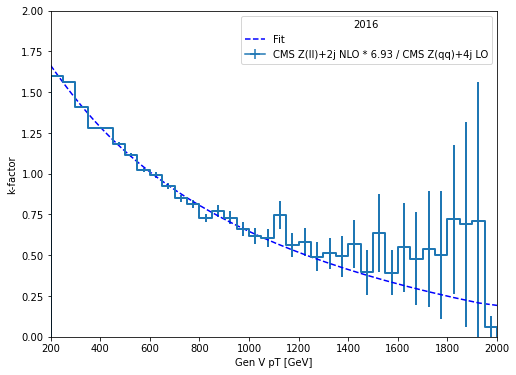

In [13]:
#Z k-factor 2016
fig, ax    = plt.subplots(figsize=(8, 6))

edges      = kFactors["2016"][0]
values     = kFactors["2016"][1]
errors     = kFactors["2016"][2]
tofxfx_fit = polyfit(edges,values,errors, deg=3)

x = np.geomspace(200, 3000)
z_tofxfx_corr16 = Correction(
    name="Z_MLM2016toFXFX",
    version=1,
    description="CMS Z(ll)+2j NLO * 6.93 / CMS Z(qq)+4j MLM",
    inputs=[vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "binning",
        "input": "vpt",
        "edges": [199, 200, 2000, 2001],
        "content": [
            np.polyval(tofxfx_fit, np.log(200)),
            {
                "nodetype": "formula",
                "variables": ["vpt"],
                "parser": "TFormula",
                "expression": horner(tofxfx_fit, "log(x)"),
            },
            np.polyval(tofxfx_fit, np.log(2000)),
        ],
        "flow": "clamp",
    },
)


ax.plot(x, evaluator(z_tofxfx_corr16)(x), label="Fit", color="b", linestyle="--")
hep.histplot(values,edges,yerr=errors,label="CMS Z(ll)+2j NLO * 6.93 / CMS Z(qq)+4j LO",linewidth=2,histtype="step")



#ax.set_xscale("log")
ax.set_ylim(0, 2)
ax.set_xlim(200, 2000)
ax.set_ylabel("k-factor")
ax.set_xlabel("Gen V pT [GeV]")
ax.legend(title="2016")
fig.savefig("Z_kCMS_2016.pdf")

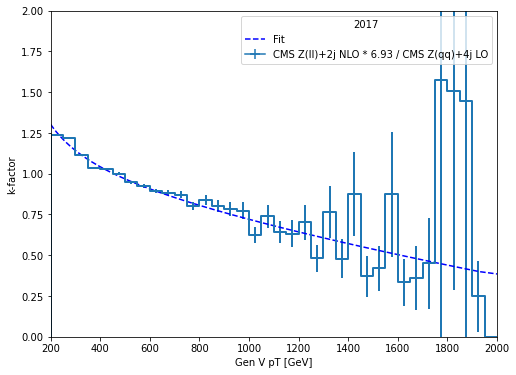

In [14]:
#Z k-factor 2017
fig, ax    = plt.subplots(figsize=(8, 6))

edges      = kFactors["2017"][0]
values     = kFactors["2017"][1]
errors     = kFactors["2017"][2]
tofxfx_fit = polyfit(edges,values,errors, deg=3)

z_tofxfx_corr = Correction(
    name="Z_MLM2017toFXFX",
    version=1,
    description="CMS Z(ll)+2j NLO * 6.93 / CMS Z(qq)+4j MLM",
    inputs=[vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "binning",
        "input": "vpt",
        "edges": [199, 200, 2000, 2001],
        "content": [
            np.polyval(tofxfx_fit, np.log(200)),
            {
                "nodetype": "formula",
                "variables": ["vpt"],
                "parser": "TFormula",
                "expression": horner(tofxfx_fit, "log(x)"),
            },
            np.polyval(tofxfx_fit, np.log(2000)),
        ],
        "flow": "clamp",
    },
)


ax.plot(x, evaluator(z_tofxfx_corr)(x), label="Fit", color="b", linestyle="--")
hep.histplot(values,edges,yerr=errors,label="CMS Z(ll)+2j NLO * 6.93 / CMS Z(qq)+4j LO",linewidth=2,histtype="step")



#ax.set_xscale("log")
ax.set_ylim(0, 2)
ax.set_xlim(200, 2000)
ax.set_ylabel("k-factor")
ax.set_xlabel("Gen V pT [GeV]")
ax.legend(title="2017")
fig.savefig("Z_kCMS_2017.pdf")

Calculation of NLO/LO QCD W->qq k-factors starts here

In [15]:
rebinning     = 5
shapesFile    = r.TFile.Open("NLOcheck.root")
kFactors      = {}
#Z+Jets corrections
ptNLO         = shapesFile.Get("WJetsToLNu_2017_gen_V_pT")
ptNLO.Scale(2.09)#BR(W->qq)/BR(W->lnu)
ptNLO.RebinX(rebinning)

for year in ["2016","2017"]:
    ptLO        = shapesFile.Get("WJets_{0}_gen_V_pT".format(year))
    ptLO.RebinX(rebinning)
    kFacPrefit  = ptNLO.Clone("k_prefit_{0}".format(year))
    kFacPrefit.Divide(ptLO)
    
    errors          = getErrors(kFacPrefit)    
    values, edges   = hist2array(kFacPrefit,return_edges=True)
    edges           = edges[0]
    kFactors[year]  = [edges,values,errors]

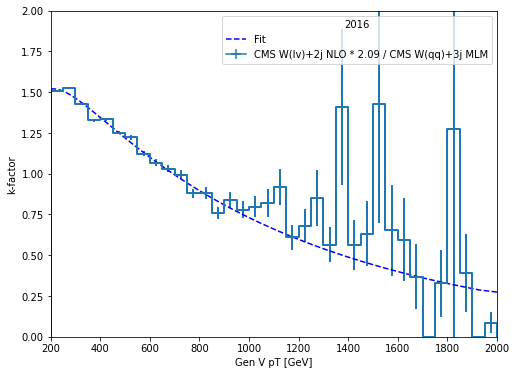

In [16]:
#W k-factor 2016
fig, ax    = plt.subplots(figsize=(8, 6))

edges      = kFactors["2016"][0]
values     = kFactors["2016"][1]
errors     = kFactors["2016"][2]
tofxfx_fit = polyfit(edges,values,errors, deg=3)

w_tofxfx_corr16 = Correction(
    name="W_MLM2016toFXFX",
    version=1,
    description="CMS W(lv)+2j NLO * 2.09 / CMS W(qq)+3j MLM 2016",
    inputs=[vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "binning",
        "input": "vpt",
        "edges": [199, 200, 2000, 2001],
        "content": [
            np.polyval(tofxfx_fit, np.log(200)),
            {
                "nodetype": "formula",
                "variables": ["vpt"],
                "parser": "TFormula",
                "expression": horner(tofxfx_fit, "log(x)"),
            },
            np.polyval(tofxfx_fit, np.log(2000)),
        ],
        "flow": "clamp",
    },
)


ax.plot(x, evaluator(w_tofxfx_corr16)(x), label="Fit", color="b", linestyle="--")
hep.histplot(values,edges,yerr=errors,label="CMS W(lv)+2j NLO * 2.09 / CMS W(qq)+3j MLM",linewidth=2,histtype="step")



#ax.set_xscale("log")
ax.set_ylim(0, 2)
ax.set_xlim(200, 2000)
ax.set_ylabel("k-factor")
ax.set_xlabel("Gen V pT [GeV]")
ax.legend(title="2016")
fig.savefig("W_kCMS_2016.pdf")

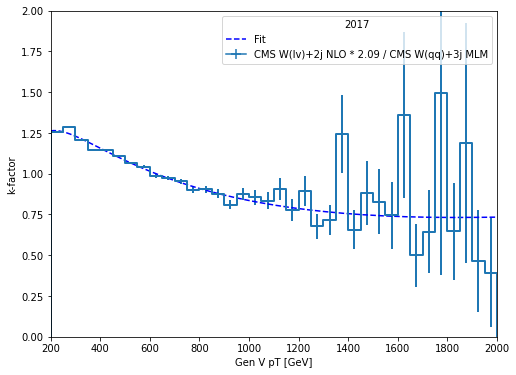

In [17]:
#W k-factor 2017
fig, ax    = plt.subplots(figsize=(8, 6))

edges      = kFactors["2017"][0]
values     = kFactors["2017"][1]
errors     = kFactors["2017"][2]
tofxfx_fit = polyfit(edges,values,errors, deg=3)

w_tofxfx_corr = Correction(
    name="W_MLM2017toFXFX",
    version=1,
    description="CMS W(lv)+2j NLO * 2.09 / CMS W(qq)+3j MLM 2017",
    inputs=[vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "binning",
        "input": "vpt",
        "edges": [199, 200, 2000, 2001],
        "content": [
            np.polyval(tofxfx_fit, np.log(200)),
            {
                "nodetype": "formula",
                "variables": ["vpt"],
                "parser": "TFormula",
                "expression": horner(tofxfx_fit, "log(x)"),
            },
            np.polyval(tofxfx_fit, np.log(2000)),
        ],
        "flow": "clamp",
    },
)


ax.plot(x, evaluator(w_tofxfx_corr)(x), label="Fit", color="b", linestyle="--")
hep.histplot(values,edges,yerr=errors,label="CMS W(lv)+2j NLO * 2.09 / CMS W(qq)+3j MLM",linewidth=2,histtype="step")



#ax.set_xscale("log")
ax.set_ylim(0, 2)
ax.set_xlim(200, 2000)
ax.set_ylabel("k-factor")
ax.set_xlabel("Gen V pT [GeV]")
ax.legend(title="2017")
fig.savefig("W_kCMS_2017.pdf")

In [18]:
cset = CorrectionSet(
    schema_version=2,
    corrections=[
        z_tofxfx_corr,
        z_tofxfx_corr16,
        z_fixedorder_corr,
        w_tofxfx_corr,
        w_tofxfx_corr16,
        w_fixedorder_corr,
    ]
)

import rich

rich.print(cset)
with open("vjets_corrections.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))

CorrectionSet (schema v2)                                                                    
No description                                                                               
📂                                                                                           
├── 📈 Z_MLM2017toFXFX (v1)                                                                  
│   CMS Z(ll)+2j NLO * 6.93 / CMS Z(qq)+4j MLM                                               
│   Node counts: Binning: 1, Formula: 1                                                      
│   ╭─────────────────────────────────────── ▶ input ───────────────────────────────────────╮
│   │ vpt (real)                                                                            │
│   │ Generated boson pT (status 62: fromHardProcess, isLastCopy) or sum(leptons).pt if     │
│   │ virtual                                                                               │
│   │ Range: [-inf, inf), overflow ok                                                       │
│   ╰───────────────────────────────────────────────────────────────────────────────────────╯
│   ╭─────── ◀ output ────────╮                                                              
│   │ out (real)              │                                                              
│   │ Multiplicative k-factor │                                                              
│   ╰─────────────────────────╯                                                              
├── 📈 Z_MLM2016toFXFX (v1)                                                                  
│   CMS Z(ll)+2j NLO * 6.93 / CMS Z(qq)+4j MLM                                               
│   Node counts: Binning: 1, Formula: 1                                                      
│   ╭─────────────────────────────────────── ▶ input ───────────────────────────────────────╮
│   │ vpt (real)                                                                            │
│   │ Generated boson pT (status 62: fromHardProcess, isLastCopy) or sum(leptons).pt if     │
│   │ virtual                                                                               │
│   │ Range: [-inf, inf), overflow ok                                                       │
│   ╰───────────────────────────────────────────────────────────────────────────────────────╯
│   ╭─────── ◀ output ────────╮                                                              
│   │ out (real)              │                                                              
│   │ Multiplicative k-factor │                                                              
│   ╰─────────────────────────╯                                                              
├── 📈 Z_FixedOrderComponent (v1)                                                            
│   Z boson K_TH(vpt, ...) / K_NLO(vpt, ...)                                                 
│   Node counts: Category: 1, Binning: 13                                                    
│   ╭─────────────────────────────────────── ▶ input ───────────────────────────────────────╮
│   │ systematic (string)                                                                   │
│   │ No description                                                                        │
│   │ Values: Z_d2kappa_EW_down, Z_d2kappa_EW_up, Z_d3kappa_EW_down, Z_d3kappa_EW_up,       │
│   │ d1K_NLO_down, d1K_NLO_up, d1kappa_EW_down, d1kappa_EW_up, d2K_NLO_down, d2K_NLO_up,   │
│   │ d3K_NLO_down, d3K_NLO_up, nominal                                                     │
│   ╰───────────────────────────────────────────────────────────────────────────────────────╯
│   ╭─────────────────────────────────────── ▶ input ───────────────────────────────────────╮
│   │ vpt (real)                                                                            │
│   │ Generated boson pT (status 62: fromHardProcess, isLastCopy) or sum(leptons).pt if     │
│   │ virtual                                           

[StepArtists(step=<matplotlib.lines.Line2D object at 0x7fe6bc7e8f60>, errorbar=None, legend_artist=None),
 StepArtists(step=<matplotlib.lines.Line2D object at 0x7fe6bc7a45f8>, errorbar=None, legend_artist=None)]

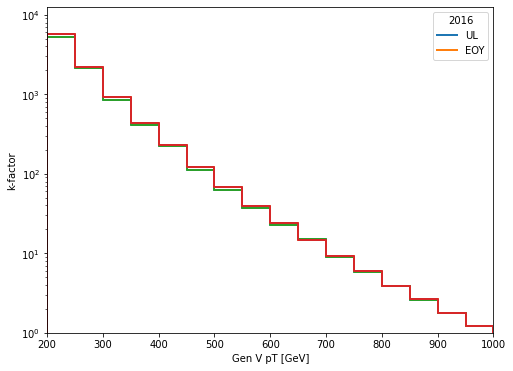

TFile**		NLOcheck.root	
 TFile*		NLOcheck.root	
  KEY: TH1D	DYJetsToLL_2016_gen_V_pT;1	
  KEY: TH1D	DYJetsToLL_2017_gen_V_pT;1	
  KEY: TH1D	DYJetsToLL_UL_2018_gen_V_pT;1	
  KEY: TH1D	WJetsToLNu_2017_gen_V_pT;1	
  KEY: TH1D	WJets_2016_gen_V_pT;1	
  KEY: TH1D	WJets_2017_gen_V_pT;1	
  KEY: TH1D	WJets_2018_gen_V_pT;1	
  KEY: TH1D	ZJets_2016_gen_V_pT;1	
  KEY: TH1D	ZJets_2017_gen_V_pT;1	
  KEY: TH1D	ZJets_2018_gen_V_pT;1	


In [31]:
f = r.TFile.Open("NLOcheck.root")
f.ls()
h1 = f.Get("DYJetsToLL_UL_2018_gen_V_pT")
h2 = f.Get("DYJetsToLL_2017_gen_V_pT")

h1.RebinX(5)
h2.RebinX(5)

ratio = h2.Clone("ratio")
ratio.Divide(h1)

h1, edges   = hist2array(h1,return_edges=True)
h2          = hist2array(h2,return_edges=False)
hRatio      = hist2array(ratio,return_edges=False)


fig, ax    = plt.subplots(figsize=(8, 6))
hep.histplot([h1,h2],edges[0],label=["UL","EOY"],linewidth=2,histtype="step")
ax.set_yscale("log")
ax.set_ylim(1, None)
ax.set_xlim(200, 1000)
ax.set_ylabel("k-factor")
ax.set_xlabel("Gen V pT [GeV]")
ax.legend(title="2016")


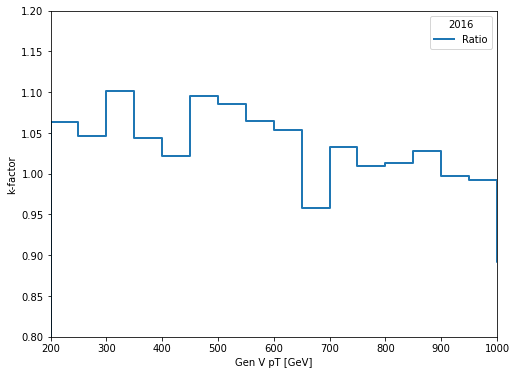

In [35]:
fig, ax    = plt.subplots(figsize=(8, 6))
hep.histplot(hRatio,edges[0],label=["Ratio"],linewidth=2,histtype="step")
ax.set_ylim(0.8, 1.2)
ax.set_xlim(200, 1000)
ax.set_ylabel("k-factor")
ax.set_xlabel("Gen V pT [GeV]")
ax.legend(title="2016")